# Libraries

In [1]:
%reset
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# nltk.download('stopwords')

import re
import scipy
import seaborn as sns
import time
import os

import numpy as np
import pandas as pd

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #Disables warning
import tensorflow as tf
from tensorflow import random
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
### Set Seeds ###
seed_value = np.uint64(np.random.randint(0,2147483647))
seed_value = np.uint64(340733825)
print("Using seeds: ",seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)
np.random.seed(seed_value)
random.set_seed(seed_value)

Using seeds:  340733825


# Dataset Handling

In [3]:
### Load csv. datasets ###
main_file = '.\\Datasets\\'
train_df = os.path.join(main_file, 'Corona_NLP_train.csv')
test_df = os.path.join(main_file, 'Corona_NLP_test.csv')

In [4]:
train_dataset = pd.read_csv(train_df, encoding = 'latin1')
test_dataset = pd.read_csv(test_df, encoding = 'latin1')

print('Train dataset: {}'.format(len(train_dataset)))
print('Test dataset: {}'.format(len(test_dataset)))

Train dataset: 41157
Test dataset: 3798


In [5]:
train_dataset.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [6]:
### Check missing and unique values ###
train_dataset.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

# Data Pre-processing

In [7]:
X_train = train_dataset['OriginalTweet'].copy()
y_train = train_dataset['Sentiment'].copy()

In [8]:
def excess_cleaning(tweets):
    
    # removing html tags
    tweets = re.sub(r'<.*?>',' ', tweets)
    # removing urls
    tweets = re.sub(r'http\S+',' ',tweets)
    # removing mentions
    tweets = re.sub(r'@\w+',' ',tweets)
    # removing hashtags
    tweets = re.sub(r'#\w+',' ',tweets)
    #removing digits
    tweets = re.sub(r'\d+',' ', tweets)
    
    # removing stop words/commonly used words
    tweets = tweets.split()
    tweets = " ".join([word for word in tweets if not word in stop_words])
    
    return tweets

stop_words = stopwords.words('english')
X_new = X_train.apply(excess_cleaning)
X_new.head()

0                                                     
1    advice Talk neighbours family exchange phone n...
2    Coronavirus Australia: Woolworths give elderly...
3    My food stock one empty... PLEASE, panic, THER...
4    Me, ready go supermarket outbreak. Not I'm par...
Name: OriginalTweet, dtype: object

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_new)
vocabulary_size = len(tokenizer.word_index)+1
print("Vocabulary size: {}".format(vocabulary_size))
print("\nCase 1:\n")
print("Sentence:\n{}".format(X_new[6]))

X_train = tokenizer.texts_to_sequences(X_new)
print("\nAfter tokenizing :\n{}".format(X_train[6]))

X_train = pad_sequences(X_train, padding='post')
print("\nAfter padding :\n{}".format(X_train[6]))

Vocabulary size: 35900

Case 1:

Sentence:
Cashier grocery store sharing insights To prove credibility commented "I'm Civics class I know I'm talking about".

After tokenizing :
[1172, 7, 4, 1267, 769, 65, 2895, 9737, 9738, 153, 18242, 1501, 2, 62, 153, 899, 957]

After padding :
[ 1172     7     4  1267   769    65  2895  9737  9738   153 18242  1501
     2    62   153   899   957     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]


In [10]:
ord_encoded = {'Extremely Negative': 0,
            'Negative': 0,
            'Neutral': 1,
            'Positive':2,
            'Extremely Positive': 2
           }

labels = ['Negative',
          'Neutral',
          'Positive']
           
y_train.replace(ord_encoded, inplace=True)

In [11]:
### hyper parameters ###
EPOCHS = 2
BATCH_SIZE = 32
embedding_dimension = 16
units = 256
validation_split = 0.12
verbose = 1

# Model Architecture

In [12]:
%%time
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    model.Embedding(vocabulary_size, embedding_dimension, input_length=X_train.shape[1]),
    model.Bidirectional(model.LSTM(units,return_sequences=True)),
    model.GlobalMaxPool1D(),
    model.Dropout(0.4),
    model.Dense(64, activation="relu"),
    model.Dropout(0.4),
    model.Dense(3)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 54, 16)            574400    
_________________________________________________________________
bidirectional (Bidirectional (None, 54, 512)           559104    
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

In [13]:
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [14]:
CALLBACKS = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [15]:
%%time
history = model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    validation_split=validation_split,
                    verbose=verbose,
                    batch_size=BATCH_SIZE,
                    callbacks=CALLBACKS)

Epoch 1/2
1132/1132 [==============================] - 251s 212ms/step - loss: 0.6743 - accuracy: 0.7028 - val_loss: 0.4097 - val_accuracy: 0.8571
Epoch 2/2
1132/1132 [==============================] - 240s 212ms/step - loss: 0.3396 - accuracy: 0.8907 - val_loss: 0.3564 - val_accuracy: 0.8803
CPU times: total: 52min 45s
Wall time: 8min 11s


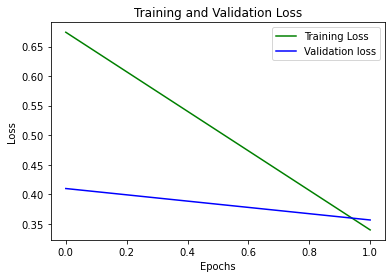

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'g', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

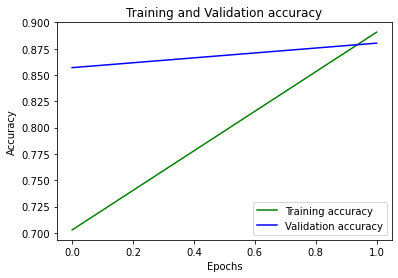

In [17]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'g', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [18]:
X_test = test_dataset['OriginalTweet'].copy()
y_test = test_dataset['Sentiment'].copy()

X_test = X_test.apply(excess_cleaning)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, padding='post')

y_test.replace(ord_encoded, inplace=True)

In [19]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
score = model.evaluate(X_test, y_test, verbose = 0, batch_size = BATCH_SIZE)
print()

print("ACCURACY: ", score[1])
print("LOSS: ", score[0])


ACCURACY:  0.855186939239502
LOSS:  0.41730010509490967


In [20]:
model.save('.\\Covid19_Analysis\\Datasets\\best_sentimentanalysis_model.h5')

In [21]:
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

    Negative       0.88      0.82      0.85      1633
     Neutral       0.89      0.79      0.84       619
    Positive       0.82      0.91      0.86      1546

    accuracy                           0.86      3798
   macro avg       0.86      0.84      0.85      3798
weighted avg       0.86      0.86      0.85      3798



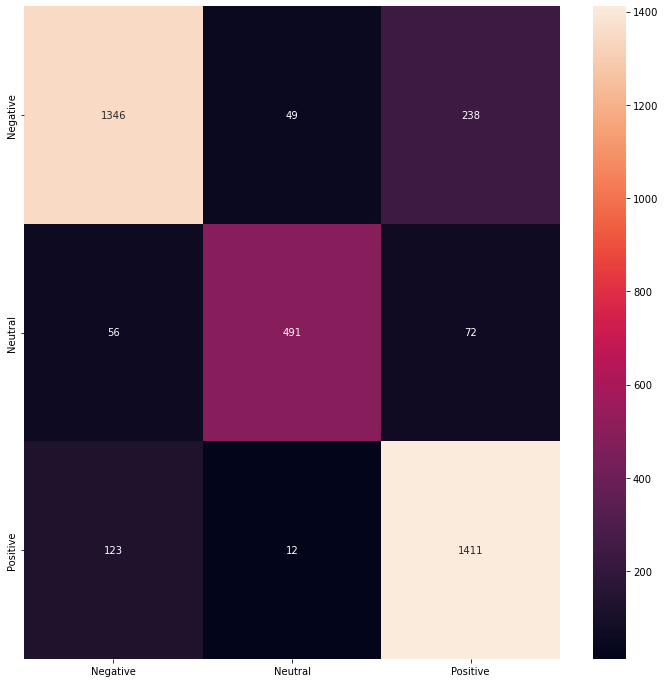

In [22]:
conf_mat = confusion_matrix(y_test, y_pred)

cm = pd.DataFrame(
    conf_mat, index = [i for i in labels],
    columns = [i for i in labels]
)

plt.figure(figsize = (12,12))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

In [23]:
max_length = 350
### Predict if tweet is positive or negative ###
def predict_sentiment(input):
    tweet = input
    tweet_sequences = tokenizer.texts_to_sequences(tweet)
    # Padded Sequence
    padded = pad_sequences(tweet_sequences, padding='post', maxlen=max_length)
    # Obtain based on probability 1 if probability >= 0.5 else 0
    prediction = y_pred 
    pred_labels = []
    for i in prediction:
        if i >= 0.5:
            pred_labels.append(1)
        else:
            pred_labels.append(0)
    for i in range(len(tweet)):
        print(tweet[i])
        if pred_labels[i] == 1:
            s = 'Positive'
        elif pred_labels[i] == 0:
            s = 'Negative'
        else:
            s = 'Neutral'
        print("Predicted sentiment : ",s)

In [24]:
predict_sentiment(["Covid brings catastrophic effect on your body", 
                   "It would better to stay away from Covid",
                   "Not going outside is a must",
                   "We dont want people to be coughing outside",
                   "Always wear your mask outside"])

Covid brings catastrophic effect on your body
Predicted sentiment :  Negative
It would better to stay away from Covid
Predicted sentiment :  Positive
Not going outside is a must
Predicted sentiment :  Positive
We dont want people to be coughing outside
Predicted sentiment :  Negative
Always wear your mask outside
Predicted sentiment :  Positive


# Hyper-Parameter Tuning for 2 max trials with 2 epochs

In [29]:
%%time
#2 epoch con 2 max_trials
from tensorflow import keras
from keras_tuner import BayesianOptimization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, GlobalMaxPool1D


def build_model(hyperparameter):
    model = Sequential()
    hp_units1 = hyperparameter.Int('units1', min_value=32, max_value=512, step=32)
    hp_units2 = hyperparameter.Int('units2', min_value=32, max_value=512, step=32)
    model.add(Embedding(vocabulary_size, embedding_dimension, input_length = X_train.shape[1]))
    model.add(Bidirectional(LSTM(units = hp_units1,return_sequences=True))) #model.add(Bidirectional(LSTM(units = hp.Int(units, min_value = 32, max_value = 512, step = 32),return_sequences=True)))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.4))
    model.add(Dense(units = hp_units2, activation = 'relu')) #model.add(Dense(units = hp.Int(64, min_value = 32, max_value = 512, step = 32), activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(3))

    model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'], 
                  optimizer=Adam(hyperparameter.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])))

    return model

bayesian_optimizer_tuner = BayesianOptimization(build_model,
                                                objective='accuracy',
                                                max_trials=2,
                                                executions_per_trial=1,
                                                directory=os.path.normpath('.\\Datasets\\'),
                                                project_name = 'sentiment_analysis_covid19_tweets',
                                                overwrite=True)

EVALUATION_INTERVAL = 200
EPOCHS = 2
stop_early = EarlyStopping(monitor='val_loss', patience=5) #min_delta=1e-4, patience=5

bayesian_optimizer_tuner.search(X_train, y_train,
                               epochs=EPOCHS,
                               validation_data=(X_test, y_test),
                               validation_steps=50,
                               validation_split=1.2,
                               steps_per_epoch=EVALUATION_INTERVAL,
                               callbacks=[stop_early]
                               #verbose=1
                               )

bayes_opt_model_best_model = bayesian_optimizer_tuner.get_best_models(num_models=1)
model = bayes_opt_model_best_model

Trial 2 Complete [00h 01m 33s]
accuracy: 0.8966135382652283

Best accuracy So Far: 0.8966135382652283
Total elapsed time: 00h 02m 48s
INFO:tensorflow:Oracle triggered exit
CPU times: total: 14min 57s
Wall time: 2min 52s


In [31]:
bayesian_optimizer_tuner.search_space_summary()


Search space summary
Default search space size: 3
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [32]:
bayesian_optimizer_tuner.results_summary()

Results summary
Results in C:\Users\jlder\Nonstop Projects\Datasets\sentiment_analysis_covid19_tweets
Showing 10 best trials
Objective(name='accuracy', direction='max')
Trial summary
Hyperparameters:
units1: 96
units2: 416
learning_rate: 0.01
Score: 0.8966135382652283
Trial summary
Hyperparameters:
units1: 64
units2: 224
learning_rate: 0.01
Score: 0.894274890422821


In [33]:
best_model = model[0]
best_model.fit(X_train, y_train)

1287/1287 [==============================] - 140s 102ms/step - loss: 0.3543 - accuracy: 0.886649s - lo - ETA: 46s - loss: 0.3626 - accurac


In [35]:
best_model.save("best_model2.h5")